## Classifying MNIST with Le-Net (MyGrad)

In this notebook, we will be training a convolutional neural network (using the Le-Net design described in this paper: http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) to classify hand-written digits. We will be using the MNIST dataset, which contains labeled images of hand-written digits from 0 to 9 (http://yann.lecun.com/exdb/mnist/). The MNIST dataset has a training set of 60,000 images and a test set of 10,000 images. 

You should have downloaded the [DataSets repo](https://github.com/LLCogWorks2017/DataSets) and installed it. This provides you with the mnist dataset, and a function for loading it.

We will be using LeNet architecture, which was one of the first convolutional neural network designs. We will explain the architecture and operations used in convolutional neural nets throughout this notebook. 




In [1]:
import numpy as np
from mygrad import Tensor
from mygrad.nnet.layers import *
from mygrad.nnet.activations import *

try:
    from jupyterthemes import jtplot
    jtplot.style()
except ImportError:
    pass

import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

### MNIST Data Loading and Preprocessing

First, we want to write a few functions that will help us with loading and processing data. To load and process our MNIST data, we will need functions to first load the data as a tuple of the training and testing data and labels, a function to create a normal distribution centered at 0 with a variance calculated using He initialization, a function to create a uniform distribution centered at 0 with variance calculated with the Xavier initialization, and a function (much like ones we've written before) to measure the accuracy of our predictions in comparison to the actual labels of the testing set. 

If you would like to read more about how Xavier Glorot explains the rationalization behind these weight initializations, look here for his paper written with Yoshua Bengio. (http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

In [8]:
def load_numpy_data(fname, entries=('x_train', 'y_train', 'x_test', 'y_test')):
    '''
    Arguments: 
    fname: the file from which you are loading data
    entries: the typical set of labeled training data and labeled test data 
    
    Functionality: 
    Process the data in fname as a tuple of all data.
    '''
    with np.load(fname) as data:
        out = tuple(data[str(key)] for key in entries)
    return out

def he_normal(shape, gain):
    '''
    Arguments:
    shape: tuple, dimensions of layer
    gain: the scalar by which you will scale the variance.
    
    Functionality: 
    Create a normal distribution centered at 0 with a variance calculated with He initialization.
    
    He weight initialization is initializing a normal distribution with a standard deviation of sigma=gain*sqrt{1/fan_in}
    Recall also that to calculate fan_in, you simply multiply fan_in = n_feature_maps_in * receptive_field_height * receptive_field_width
    '''
    if len(shape) == 2:
        n = shape[0]
    else:
        n = np.prod(shape[1:])
    scale = gain * np.sqrt(1. / n)
    return np.random.randn(*shape)*scale

def xavier_uniform(shape, gain):
    '''
    Arguments:
    shape: tuple, dimensions of layer
    gain: the scalar by which you will scale the variance.
    
    Functionality:
    Create a uniform distribution centered at 0 with a variance calculated with Xavier initialization. 
    Xavier initialization of a uniform distribution is scaled such that the standard deviation is 
    sigma = gain*sqrt{6/fan_in}
    '''
    n = shape[0] + shape[1]
    if len(shape) > 2:
        n *= np.prod(shape[2:])  # multiply by the receptive field
    scale = gain * np.sqrt(6. / n) 
    return np.random.uniform(low=-scale, high=scale, size=shape)

def measure_acc(ypred, ytrain):
    '''
    Arguments: 
    ypred, ytrain - your predicted labels and your actual labels from your training set. 
    
    Functionality:
    Much like in previous notebooks, calculate the accuracy of your predictions based on existing labels
    '''
    return np.mean(np.argmax(ypred, axis=1) == np.argmax(ytrain, axis=1))

Now, load your data from mnist.npz using your load_numpy_data function.

In [1]:
from datasets import load_mnist

In [2]:
xtr, ytr, xte, yte = (i.astype("float32") for i in load_mnist())
xtr /= 255.
xte /= 255.

mnist loaded


In [3]:
xtr.shape

(60000, 1, 32, 32)

### Creating Layers of our ConvNet

Now, we will construct the main architecture for our convolutional neural network. 

The main difference between the neural networks we have previously discussed and a convolutional neural network is that every layer in a CNN maps a 3-D input to a 3-D output. 



![check out this diagram](cnn_diagram.jpg)

So how does this work? There are three types of layers used in convnets--convolutional layers, pooling layers, and dense layers. 

In CNN's, convolutions are meant to preserve the spatial relationships between pixels in the input image. Essentially, a filter is convolved upon the image, (see here for a nice gif, just ctrl+F "convolution demo" http://cs231n.github.io/convolutional-networks/)

By sliding the filter matrix across the entire image and calculating the dot product at each position, we create the feature map, also known as a convolved feature or an activation map. Different filter matrices will create different results. 

![check out this diagram 2](matrices.png)

Then, the dimensions of the feature map are defined by depth (the number of filters applied in this convolution process), stride (the number of pixels by which we shift our filter everytime we shift to a new position), and zero-padding (adding a border of zeros around our image to allow for a "wide convolution." A image without this border of zeros, without the zero-padding, would be a "narrow convolution."

Another type of operation is ReLU. The ReLU operation is basically another filter that we can apply to an image, but rather than accepting negative values, if there are any negative values we just set it to 0. ReLU stands for Rectified Linear Unit and is a non-linear function. Below is an example of the output of applying the ReLU filter, which is applied pixel-wise. 

![check out this diagram 3](ReLU.png)

Then, we can generate an output from the convolutional layer, which we will feed into our next layer, the pooling layer. In order to prevent overfitting, we will also randomly dropout some of the values from our input data, so just use a binomial distribution with a dropout probability of 0.5 to choose which of your data values to omit. 

Another kind of layer is the pooling layer. Spatial Pooling (aka subsampling or downsampling) essentially divides up our input into different windows, and applies an operation to each window, such as max pooling, average pooling, or sum pooling. Essentialy, this just downsizes the image into a map that takes either the max, average, or sum of all values in each segment and maps that to the output. 

![check out this diagram 3](pooling1.jpg)
![check out this diagram 3](poolingimage2.jpg)

We will only be using max-pooling in this notebook, as max-pooling is usually the most effective. Note that although we are downsizing our input images by passing our inputs through a pooling layer, we apply this pooling operation separately to each feature map that is produced through our convolutional layer. Pooling makes the general amount of data we are processing more manageable, prevents overfitting (even more) by reducing the number of parameters, and minimizes the effects of small distortions in the input image (as the effect on the maximum/average will be trivial). 

Next, we also have fully-connected (FC), aka dense layers. The dense layer is like a multi-layer perceptron, and essentially generates a probability distribution across the classes, such that the generated probabilities sum to 1. Our dense layer will take the high level, distilled features that are output from the convolutional and pooling layers to process and classify the image. The dense layer is essentially what we have already done before in class. For this network, we will be using a softmax activation function to generate our output. 

In the convnet to classify MNIST images, we will construct a CNN with two convolutional layers (each structured as conv layer --> dropout --> pooling layer), one ReLU layer, and one final output layer with the softmax activation function. 

To begin, initialize the tuples representing input/output dimensions, the dimensions of our layers, stride/pool sizes, and other constants that may be useful. 

In [4]:
#Initialize two variables representing the input size and the output dimensions. Keep in mind the goal of our classifier,
#and that the size of the images will be 32x32 (as usual)
#STUDENT CODE HERE:
input_size = (1, 32, 32)
output_dims = 10

# Next, define the model parameters by initializing the dropout probability as a float, and the convolutional strides
# and pooling shape and stride. Just for good measure, try a dropout probability of 0.5.



prob = 0.5  # dropout probability (i.e., percentage of elements to randomly drop)
stride = (1, 1)  # convolutional strides
pool = (2, 2)  # pooling shape and stride


#Initialize variables representing the shape of our first and second layers, which are both convolutional, as well as 
#our third and fourth layers which will both be dense layers. Remember that the dimensisons of the layers will change 
#throughout the network. 
conv1_shape = (20, 1, 5, 5)
conv2_shape = (50, 20, 5, 5)
dense3_shape = (50*5*5, 500)
dense4_shape = (500, output_dims)


#Now, initialize the W and b parameters for our four layers using helper functions you have previously written
#for creating properly scaled probability distributions. 
W1 = Tensor(xavier_uniform(conv1_shape, 1.))

W2 = Tensor(xavier_uniform(conv2_shape, 1.))

W3 = Tensor(xavier_uniform(dense3_shape, 1.))
b3 = Tensor(np.zeros((W3.shape[1],), dtype=W3.dtype))

W4 = Tensor(xavier_uniform(dense4_shape, 1.))
b4 = Tensor(np.zeros((W4.shape[1],), dtype=W4.dtype))


#Here, create a list of the weights and biases you just initialized above and also feel free to define any 
#constants that you will refer to later for good coding practice and to make your code more readable. 
#Be sure to initialize arrays in which to store loss and accuracy as you will be graphing these later on.
params = [W1, W2, W3, b3, W4, b4]
reg = 5e-4
lr = 0.01
mu = 0.9
vs = [np.zeros_like(i.data) for i in params]
l = []
acc = []
N = 128

Now, train your classfier for 200 iterations. It should take about 6-7 minutes to run. Be sure to record loss and accuracy just as before.

In [5]:
from mygrad.math import log
from numpy.random import rand
from time import time
start = time()
for i in range(200):
    batch_ids = np.random.choice(range(xtr.shape[0]), size=N, replace=False)
    x = xtr[batch_ids]
    y = ytr[batch_ids]
    c1 = conv2d(x, W1, stride, padding=0)
    c1 *= np.random.binomial(1, (1 - p), c1.shape) / (1 - p)
    o1 = max_pool(c1, pool, pool)
    
    c2 = conv2d(o1, W2, stride, padding=0)
    c2 *= np.random.binomial(1, (1 - p), c2.shape) / (1 - p)
    o2 = max_pool(c2, pool, pool).reshape(c2.shape[0], -1)
    
    o3 = relu(dense(o2, W3) + b3)
    o3 *= np.random.binomial(1, (1 - p), o3.shape) / (1 - p)
    
    o4 = logsoftmax(dense(o3, W4) + b4)
    
    # this loss is just cross-entropy + regularization. We simply took
    # the log of the predicted-distribution in the last layer
    loss = ((y*(-1/N)*o4).sum() + (0.5*reg)*((W1**2).sum() + (W2**2).sum() + 
                                             (W3**2).sum() + (W4**2).sum())
    
    l.append(loss.data)
    loss.backward()
    acc.append(measure_acc(o4.data, y))
    
    for n, (v, w) in enumerate(zip(vs, params)):
        v *= mu
        v -= lr * w.grad
        w.data += v
    loss.null_gradients()
stop = time()
print("DONE")
print(stop-start)

DONE
413.61304783821106


Graph your loss and accuracy! These should be familiar shapes. Old friends. 

<IPython.core.display.Javascript object>


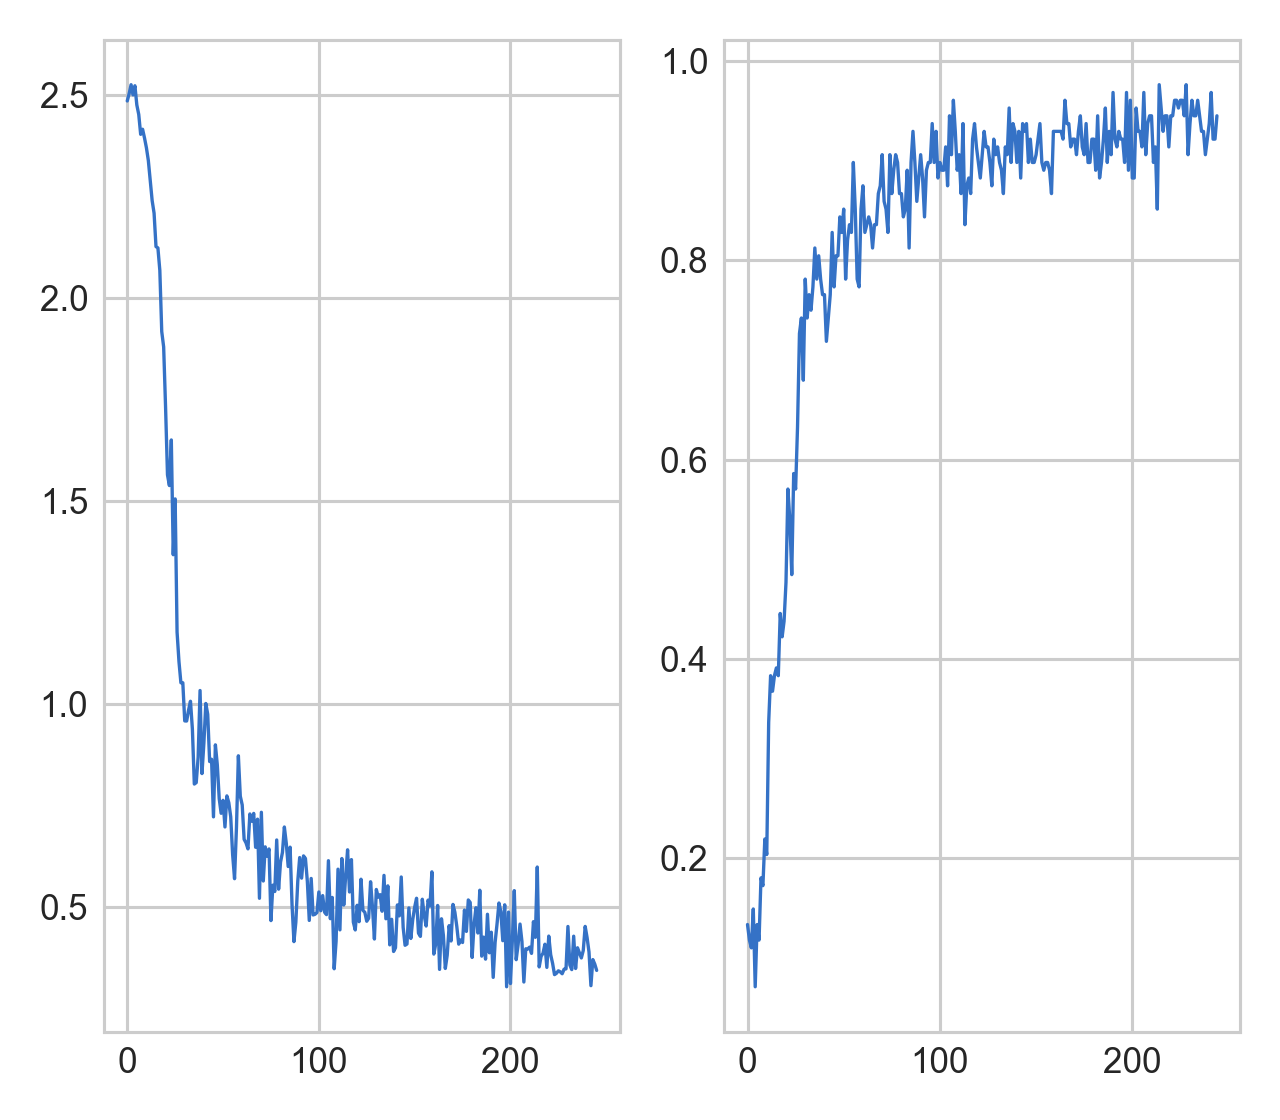

In [11]:
fig, (ax,ax2) = plt.subplots(ncols=2)
ax.plot(l)
ax2.plot(acc)

Now you've trained and tested your first convolutional neural network! If you're feeling motivated, try to create a function that will define a conv net model just like the one you've just created. 

In [7]:
def create_model():
    # dataset dependent parameters
    input_size = (1, 32, 32)
    output_dims = 10

    # model parameters
    prob = 0.5  # dropout probability (i.e., percentage of elements to randomly drop)
    stride = (1, 1)  # convolutional strides
    dilation = (1, 1)  # convolutional dilation
    pool = (2, 2)  # pooling shape and stride


    # create layers
    conv1_shape = (20, input_size[0], 5, 5)
    conv1 = ConvolutionalLayer2D('conv1', conv1_shape, stride, dilation, 'valid')
    w = xavier_uniform(conv1_shape, 1., "w", "float32")
    conv1._w.set_value(w.get_value())
    drop1 = BayesianDropoutLayer('drop1', prob)
    pool1 = PoolingLayer2D('pool1', pool, pool, 'max')

    conv2_shape = (50, 20, 5, 5)
    conv2 = ConvolutionalLayer2D('conv2', conv2_shape, stride, dilation, 'valid')
    w = xavier_uniform(conv2_shape, 1., "w", "float32")
    conv2._w.set_value(w.get_value())
    drop2 = BayesianDropoutLayer('drop2', prob)
    pool2 = PoolingLayer2D('pool2', pool, pool, 'max')
    reshape2 = ReshapeLayer('reshape2')

    dense3_shape = (50*5*5, 500)
    dense3 = DenseLayer('dense3', dense3_shape)
    w = xavier_uniform(dense3_shape, 1., "w", "float32")
    dense3._w.set_value(w.get_value())
    relu3 = ReluLayer('relu3')
    drop3 = BayesianDropoutLayer('drop3', prob)

    dense4_shape = (500, output_dims)
    dense4 = DenseLayer('dense4', dense4_shape)
    w = xavier_uniform(dense4_shape, 1., "w", "float32")
    dense4._w.set_value(w.get_value())
    softmax4 = LogSoftmaxLayer('softmax4')


    # model
    model = Model("LeNet-ALL")

    # Input layer
    model.add_input(InputLayer('input', input_size))

    # Layer 1: convolution + dropout + pooling
    model.add_layer(conv1, 'input')
    model.add_layer(drop1, 'conv1')
    model.add_layer(pool1, 'drop1')

    # Layer 2: convolution + dropout + pooling
    model.add_layer(conv2, 'pool1')
    model.add_layer(drop2, 'conv2')
    model.add_layer(pool2, 'drop2')
    model.add_layer(reshape2, 'pool2')

    # Layer 3: dense + relu + dropout

    model.add_layer(dense3, 'reshape2')
    model.add_layer(relu3, 'dense3')
    model.add_layer(drop3, 'relu3')

    # Layer 4: dense + softmax
    model.add_layer(dense4, 'drop3')
    model.add_layer(softmax4, 'dense4')

    # Output layer
    model.add_output(OutputLayer('output'), 'softmax4')
    return model